## Add Aero Forces

need to add aero moments to my aero model will do for a simple model and check result with previous method

### Preamble

In [5]:
import sympy as sym
import sympy.physics.mechanics as me
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import sympyTransforms as symt
import custom_plot_objects as cpo
import FwtModels as fm
import FwtModels.dof2 as dof2
import FwtModels.RollingModel as rm
import FwtModels.AeroModels as ams
import FwtModels.AssumedShapesNonLin as asnl

me.mechanics_printing()

### Define the Model

#### Create Parameter instance

In [6]:
half = sym.Rational(1,2)

# lets go for B2T2 (so 5 DoF)
p = fm.FwtParameters(3)

## Create some global parameters
p.c = fm.FwtVariable(0.15,'c') # chord of wing

# main Wing Structural Parameters
p.y_w = sym.Symbol('y')
p.x_w = sym.Symbol('x')

p.x_f = fm.FwtVariable(0.15,'x_f') # flexural axis location
p.s = fm.FwtVariable(10,'s') # span
p.EI = fm.FwtVariable(1e9,'EI') # EI
p.GJ = fm.FwtVariable(1e4,'GJ') # GJ

p.m = fm.FwtVariable(30,'m_t') # inner wing mass
p.rho_w = p.m/(p.c*p.s) #wing density

## FWT structural Parameters
p.y_fwt = sym.Symbol('y_fwt')
p.x_fwt = sym.Symbol('x_fwt')

p.x_ffwt = fm.FwtVariable(0.15,'x_ffwt') # flexural axis location
p.s_fwt = fm.FwtVariable(1.5,'s_fwt') # span
p.l_fwt = p.s_fwt*half # span

p.m_fwt = fm.FwtVariable(2,'m_fwt') # inner wing mass
p.I_xx_fwt = sym.Rational(1,12)*p.m_fwt*p.s_fwt**2 # inertia of FWT (uniform bar)

## Aero Parameters
p.rho = fm.FwtVariable(1.225,'rho') # density
p.V = fm.FwtVariable(10,'V') # velocity
p.g  = fm.FwtVariable(9.81,'g') # gravity
p.alpha_r = fm.FwtVariable(np.deg2rad(3),'alpha_r') # root AoA

p.a_w = fm.FwtVariable(2*np.pi,'a_w') # C_L of wing
p.M_thetadot = fm.FwtVariable(1.2,'M_thetadot')
p.e = -1*(p.x_f-sym.Rational(1,4)*p.c)

## FWT Aero Parameters
p.a_fwt = p.a_w-(p.a_w/p.s_fwt)*p.y_fwt # C_L of wing
p.Deltaalpha_fwt = fm.FwtVariable(0,'DeltaAlpha_fwt') # gravity
p.alphadot_fwt = fm.FwtVariable(0,'alphadot_fwt') # gravity
p.Lambda = fm.FwtVariable(np.deg2rad(10),'Lambda') # gravity

## force first bending mode frequency
p.f_0 = fm.FwtVariable(2,'f_0') # first Bending mode frequency
p.EI = (sym.Rational(2,3.516)*sym.pi*p.f_0)**2*p.rho_w*p.c*p.s**4

#### Create Transforms

In [3]:
#get shape functions for main wing
z_w,tau_w = asnl.ShapeFunctions_BN_TM(1,1,p.q[:2],p.y_w,p.x_w,p.x_f,0)

#define frames
wing_frame = symt.HomogenousTransform().R_y(p.alpha_r)
fwt_frame = wing_frame.Translate(p.x_f,p.s,z_w.subs({p.x_w:p.x_f,p.y_w:p.s})).R_y(tau_w.subs(p.y_w,p.s)).R_x(p.q[2])

#create flexielement
M = fm.MassMatrix(p.m)
ele = fm.FlexiElement(wing_frame,M,p.x_w,p.y_w,z_w,p.c,p.s,p.x_f,p.EI,p.GJ)

#create Fwt element
M_fwt = fm.MassMatrix(p.m_fwt,I_xx=p.I_xx_fwt)
ele_fwt = fm.RigidElement(fwt_frame.Translate(0,p.l_fwt,0),M_fwt)

fwt_GravityForces = ams.GravityModel(p,fwt_frame.Translate(0,p.l_fwt,0),sym.Matrix([0,0,p.g*p.m_fwt]))
#wing_GravityForces = ams.GravityModel(p,wing_frame,sym.Matrix([0,0,p.g*p.m_w]))

#Aero Forces
tip_aoa = tau_w.subs(p.y_w,p.s)+p.alpha_r
fwt_AeroForces = ams.AeroModelv3(p,fwt_frame.Translate(0,p.y_fwt,0),p.a_fwt,(p.y_fwt,0,p.s_fwt),0,
                                 p.Deltaalpha_fwt,p.alphadot_fwt,p.M_thetadot)

wing_frame_aero = wing_frame.Translate(0,p.y_w,z_w.subs(p.x_w,p.x_f))
wing_AeroForces = ams.AeroModelv3(p,wing_frame_aero,p.a_w,(p.y_w,0,p.s),p.alpha_r,tau_w,tau_w.diff(me.dynamicsymbols._t),p.M_thetadot)

In [4]:
#compistie force
CompositeForce = ams.CompositeForce(p,[wing_AeroForces,fwt_GravityForces,fwt_AeroForces])

sm = asnl.SymbolicModel([ele,ele_fwt],p,CompositeForce)

<function __main__.fwt_alphadot(t, x)>

## create masses 

In [156]:
tmax, dt = 40, 0.01
tau_end = sym.lambdify((p.x,),tau_w.subs({p.y_w:p.s.value}))
# Initial conditions: theta, dtheta/dt, L, dL/dt

#set velocity and alpha_r funcs
def Vfunc(t,x):
    return 40

def arfunc(t,x):
    return np.deg2rad(2)
    
def FwtAoA(Lambda,foldAngle,root_aoa):
    # get velocity vector in FWT frame
    v_x = (np.sin(Lambda)**2*np.cos(root_aoa)*np.cos(foldAngle) - np.sin(Lambda)**2*np.cos(root_aoa) - np.sin(Lambda)*np.sin(root_aoa)*np.sin(foldAngle) + np.cos(root_aoa))
    v_z = (np.sin(Lambda)*np.sin(foldAngle)*np.cos(root_aoa) + np.sin(root_aoa)*np.cos(foldAngle))
    return np.arctan(np.sin(Lambda)*np.sin(foldAngle)) + root_aoa*np.cos(foldAngle)
    
def fwt_alpha(t,x):
    root_aoa = tau_end(x) + arfunc(t,x)
    return FwtAoA(p.Lambda.value,x[-2],root_aoa)

def fwt_alphadot(t,x):
    return 0
    
p.Deltaalpha_fwt.value = fwt_alpha
p.alphadot_fwt.value = fwt_alphadot
p.V.value = Vfunc
p.alpha_r.value = arfunc

y0 = [0]*p.qs*2
y0[0] = 0
y0[2] = 0
y0[4] = 0
#y0 = [1.5,0,0.02,0]
ts = np.arange(0, tmax+dt, dt)

constraints = [np.NaN]*p.qs*2

def objectiveDeriv(t,y):
    deriv = sm.deriv(t,y,p.GetNumericTuple(y,t))
    return tuple(np.where(np.isnan(constraints),deriv,constraints))

In [157]:
t = 10
y0=[0]*6
y0[0]=-0.4
y0[0]=-0.0
y0[-2] = np.deg2rad(0)
fwt_AeroForces(p.GetNumericTuple(y0,0),y0,0)

np.rad2deg(fwt_alpha(0,y0))
#CompositeForce(p.GetNumericTuple(y0,t),y0,t)

IndexError: index 6 is out of bounds for axis 0 with size 6

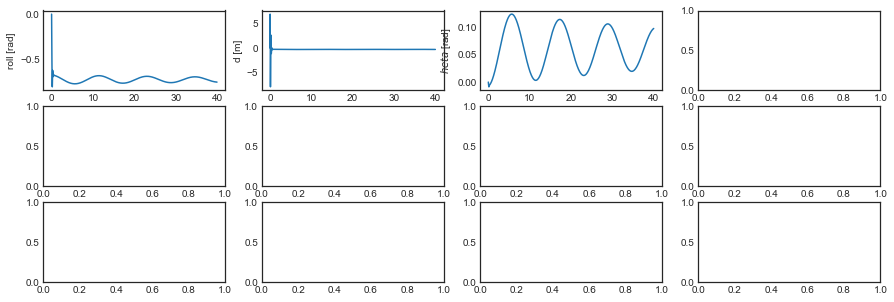

In [158]:
yData = solve_ivp(objectiveDeriv,(0,tmax),y0)

# interpolate data onto a uniform time grid

yi = yData.y
t = yData.t

plt.style.use('seaborn-white')
    
fig, axes = plt.subplots(3,4,figsize=(15,5))

# roll plot
axes[0][0].plot(t,yi[0])
axes[0][0].set_ylabel('roll [rad]')
axes[0][0].set_xlabel('t [s]')

# d plot
axes[0][1].plot(t,yi[2])
axes[0][1].set_ylabel('d [m]')
axes[0][1].set_xlabel('t [s]')

# theta plot
axes[0][2].plot(t,yi[4])
axes[0][2].set_ylabel('$\theta$ [rad]')
axes[0][2].set_xlabel('t [s]')


# theta plot
axes[0][3].plot(t,yi[6])
axes[0][3].set_ylabel('$\theta$ [rad]')
axes[0][3].set_xlabel('t [s]')

# ddot plot
axes[1][0].plot(t,yi[1])
axes[1][0].set_ylabel('$\dot{d}$ [m/s]')
axes[1][0].set_xlabel('t [s]')

# thetadot plot
axes[1][1].plot(t,yi[3])
axes[1][1].set_ylabel(r'$\dot{\theta}$ [rad/s]')
axes[1][1].set_xlabel('t [s]')

# thetadot plot
axes[1][2].plot(t,yi[5])
axes[1][2].set_ylabel(r'$\dot{\theta}$ [rad/s]')
axes[1][2].set_xlabel('t [s]')
# thetadot plot
axes[1][3].plot(t,yi[7])
axes[1][3].set_ylabel(r'$\dot{\theta}$ [rad/s]')
axes[1][3].set_xlabel('t [s]')